In [2]:
from mnist import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import cv2

### RANDOM INITIALISATION OF PARAMETERS 

In [3]:
def initialisation_parameters(K_init,img_size):
    """
    Initialise the parameters for Bernoulli mixture model
    
    Input : K_init -- No. of mixture components that density is assumed to be made up of 
    
    P_init -- Create a dictonary consisting of the inital probabilities and weightage of 
    each mixture component corresponding to each class
    
    Return : P_init
    
    """
    K=K_init   #no. of mixture components
    P_init={} 
    

    #-------------------------------------------------------------------------
    #to randomly assign the inital probabilities

    pi=np.ones((1,K))*(1/K)   #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
    P_init["lamda"]=pi[0,:]
    for k in range(K):
        #alpha=np.random.randint(1,5,size=(K,))
        #alpha=np.reshape(alpha,(3,))

      
        #np.random.rand(1,img_size)
        p=np.random.uniform(0.25,0.75,(1,img_size)) #create random prob. values for all mixture components 
        p=p/np.sum(p)
        #p=(pi@p).T

        P_init["prob"+str(k)]=p

    return P_init


### EM ALGORITHM

In [4]:
def em_algorithm(iterations,P_em,K,clas):

    """EM ALGORITHM
    Input : 
    iterations -- Maximum no. of iterations
    P_em       -- dictionary that contains probabilities and weightages of all mixture components
    K          -- no. of mixture components
    res_coeff  -- dictionary containing the responsibility coefficient of all images w.r.t each mixture component
    log_likey  -- contains log likelihood of each class for each iteration
    
    Return: 
    P_em -- Updated dictionary that contains probabilities and weightages of all mixture components of each class
    res_coeff -- Updated responsibility coefficients
    log_likely --  Updated log likelihood
    """
    
    
    ll_old=0
    ll_new=0
    log_likely=np.zeros((iterations,1))
    
    for itr in range(iterations):  
        #responsibility coefficient of size(no. of images in a class x mixture components)
        res_coeff=np.zeros((len(clas),K))  
        
        for n in range(len(clas)):
            prob_pk=np.zeros((1,K))             #probability of each mixture component 
            res_coeff_nr=np.zeros((1,K))       #to store respob. coeff of each mixture component
            
            for k in range(K):
                xn=clas[n][:]
                pk=P_em["prob"+str(k)]  #stores the probability of kth component 
                
                prob_xp1=np.power(pk,xn)            #to find pi^xi  
                #prob_xp1=np.clip(prob_xp1,1e-50,1)  #clip the values that are lesser than 1e-50
                prob_xp2=np.power(1-pk,1-xn)        #to find (1-pi)^(1-xi) 
                #prob_xp2=np.clip(prob_xp2,1e-50,1)  #clip the values that are lesser than 1e-50
                
                """when we muliply pi^xi*(1-pi)^(1-xi) the values would be very low 
                ex: if all pi=0.5 then  pi^xi*(1-pi)^(1-xi)=0.5^784=o(1e^-237), which will be close to zero.
                Hence we multiply it by 1e250. As we are doing this for each mixture component. It doesn't affect
                in the calculations of responsibility coefficient.
                We have done this to avoid res_coefficient becoming undefined value or zero for all features of a image"""
                prob_pk[0,k]=np.product(prob_xp1)*np.product(prob_xp2)*(1e250)  #probability of x given prob. of kth mixture
                
            
                #numerator of respob. coeff of nth image with kth mixture
                res_coeff_nr[0,k]=P_em["lamda"][k]*prob_pk[0,k]   
                #print(f"respb coeff nr {res_coeff_nr[0,k]}")
            
            #print(f"resolution coeff {np.sum(res_coeff_nr)}")
            
            # respob. coeff of nth image with kth mixture
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            res_coeff[n,:]=res_coeff_nr/(np.sum(res_coeff_nr)+1e-50) 

        #EXPECTATION - STEP    
        N_k=np.sum(res_coeff,axis=0) 
        #print(f"Value of {N_k}")
        
        P_em["lamda"]=N_k/len(clas)

        k=0
        for k in range(K):
            
            res_coeff_k=res_coeff[:,k]
            res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))
            
            #MAXIMISATION - STEP
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            
            P_em["prob"+str(k)]=(res_coeff_k@clas[:][:])/(N_k[k]+1e-50)  

        """Below code is find the log likelihood for the parameters obtained in the current iteration"""


        

        ll=0
        for n in range(len(clas)):
            xi=clas[n][:]
            xi=np.reshape(xi,(1,784))
            for k in range(K):
                p_i=P_em["prob"+str(k)]
                p_i=np.clip(p_i,1e-50,1)
                p_i_minus=np.log(1-p_i)
                p_i=np.log(p_i)
                ll_update=res_coeff[n,k]*(xi@p_i.T+(1-xi)@(p_i_minus).T+np.log(P_em["lamda"][k]))
                ll=ll+ll_update
                
        ll_old=ll_new
        ll_new=ll
#       print(f"log likelihood : {ll_new},old : {ll_old}")

        log_likely[itr]=ll_new


        
        if (np.abs(ll_new-ll_old)<1 and itr>=1):
            #log_likely[itr+1:iterations]=log_likely[itr]
            print(f"For iteration {itr} the difference between new log likelihood and old log likelihood is less than 1")
            break
    
    return log_likely,P_em,res_coeff,itr



### Initialisation of parameters for EM algorithm using K-means

In [5]:
def init_using_kmeans(K,iter_kmeans):
    K=K
    iterations=iter_kmeans   #no. of iterations
    P_init={}
    pi=np.ones((1,K))*(1/K)   #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
    P_init["lamda"]=pi[0,:]
    
    #random initialisation of latent variables
    #for i in range(np.max(train_labels)+1):
    z=np.random.randint(0,K,size=(classes.shape[0],1))
    #print(z)
    #print(np.max(z))
    #mu={}     #dictionary to store the mean value for each mixture component 
    tot_err=np.zeros((iterations,1))

    for itr in range(iterations):
        mu=np.zeros((K,784))
        xi_s=classes
        xi_s=np.array(xi_s)

        #print(np.shape(xi_s))
        err=np.zeros((K,1))
        for k in range(K):
            z_d=np.where(z==k,1,0)
            #print(z_d)
            #print(f"sum : {np.sum(z_d)}")
            z_d=z_d.T

            #find the mean value of kth mixture component using the images that belong to the kth mixture 
            mu_k=(z_d@xi_s)/(np.sum(z_d))    
            mu_k=np.reshape(mu_k,(1,784))
            #print(np.max(mu_k))
            mu[k,:]=mu_k

            error=z_d@(xi_s-mu_k)
            err[k]=err[k]+np.linalg.norm(error)


        for n in range(len(xi_s)):
            xn=xi_s[n][:]-mu
            #print(np.shape(xn))
            min_dist=np.linalg.norm(xn,axis=1)

            z[n]=np.argmin(min_dist)  #store the distance  that is minimum among all the mixture components 

        #print(min_dist)

        z[n]=np.argmin(min_dist)
        #print(min_dist)

        total_err=np.sum(err)
        #print(f"total error : {total_err}")


#         if total_err<1e-20:
#           print(f"The iteration no. at which the total_err is less than 1e-20 is {total_err}: corresponding iteration is {itr}")
#           break

    #plot the images for each class using the avearge mean obtained by taking mean over all mixture components 
    plt.figure(figsize=(64,64))    #to specify the figure size
    print("Images after initialistion of parameters using K-means")
    for i in range(K):
        plt.subplot(1,K,i+1)
        train_image=mu[i,:]
        #train_imag1=np.where(train_imag1>0.5,1, 0)
        train_image=np.reshape(train_image,(28,28))
        #train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
        plt.imshow(train_image,cmap='gray')
        plt.axis('off')
    for k in range(K):
        P_init["prob"+str(k)]=mu[k,:]
    return P_init



### LOAD THE MNIST DATA AND CLASSIFFY THE DATA TO THEIR RESPECTIVE CLASSES

In [6]:
"""Extract MNIST data from the specified folder. mndata has images of numbers 0-9 with their respective labels.

    train_images -- training set represented by a numpy array of shape (no of images=60000,size of each image=784 )
    train_labels -- training labels represented by a numpy array (vector) of shape (no of images=60000,1)
    test_images  -- test set represented by a numpy array of shape (no of images=10000,size of each image=784)
    test_labels  -- test labels represented by a numpy array (vector) of shape (no of images=10000,1)
"""

mndata=MNIST(r"Dataset_spr_2")

train_images, train_labels=mndata.load_training()      #loads training images and their labels
test_images, test_labels=mndata.load_testing()     #loads testing images and their labels
test_images=np.array(test_images)
#print(np.shape(test_images))

"""to convert gray scale image to binary image"""
train_images=np.array(train_images)
train_images=np.where(train_images > 127, 1,0 )
test_images=np.array(test_images)
test_images=np.where(test_images > 127, 1,0 )

"""classes -- list with each item containing images of that particular class """

train_size=len(train_labels)     #no. of images in training set
test_size=len(test_labels)       #no. of images in testing set
img_size=train_images.shape[1]

N_class=np.max(train_labels)+1   #total no. of classes
all_classes=[[] for i in range(N_class)]  
for i in range(train_size):
      all_classes[train_labels[i]].append(train_images[i]) # the images with label k is added to the class k. 

#actual question starts from here
K=3  #no. of mixture components
n_img=200 #no. of images from each set
class_no=np.array([2,3,4])
classes=np.array(all_classes[class_no[0]][:n_img][:])
for i in range(len(class_no)-1):
    classes=np.append(classes,all_classes[class_no[i+1]][:n_img][:],axis=0)
# classes=np.append(classes,all_classes[4][:200][:],axis=0)
classes=np.random.permutation(classes)





### RUN THE BELOW CELL TO IMPLEMENT EM ALGORITHM

Images after initialistion of parameters using K-means


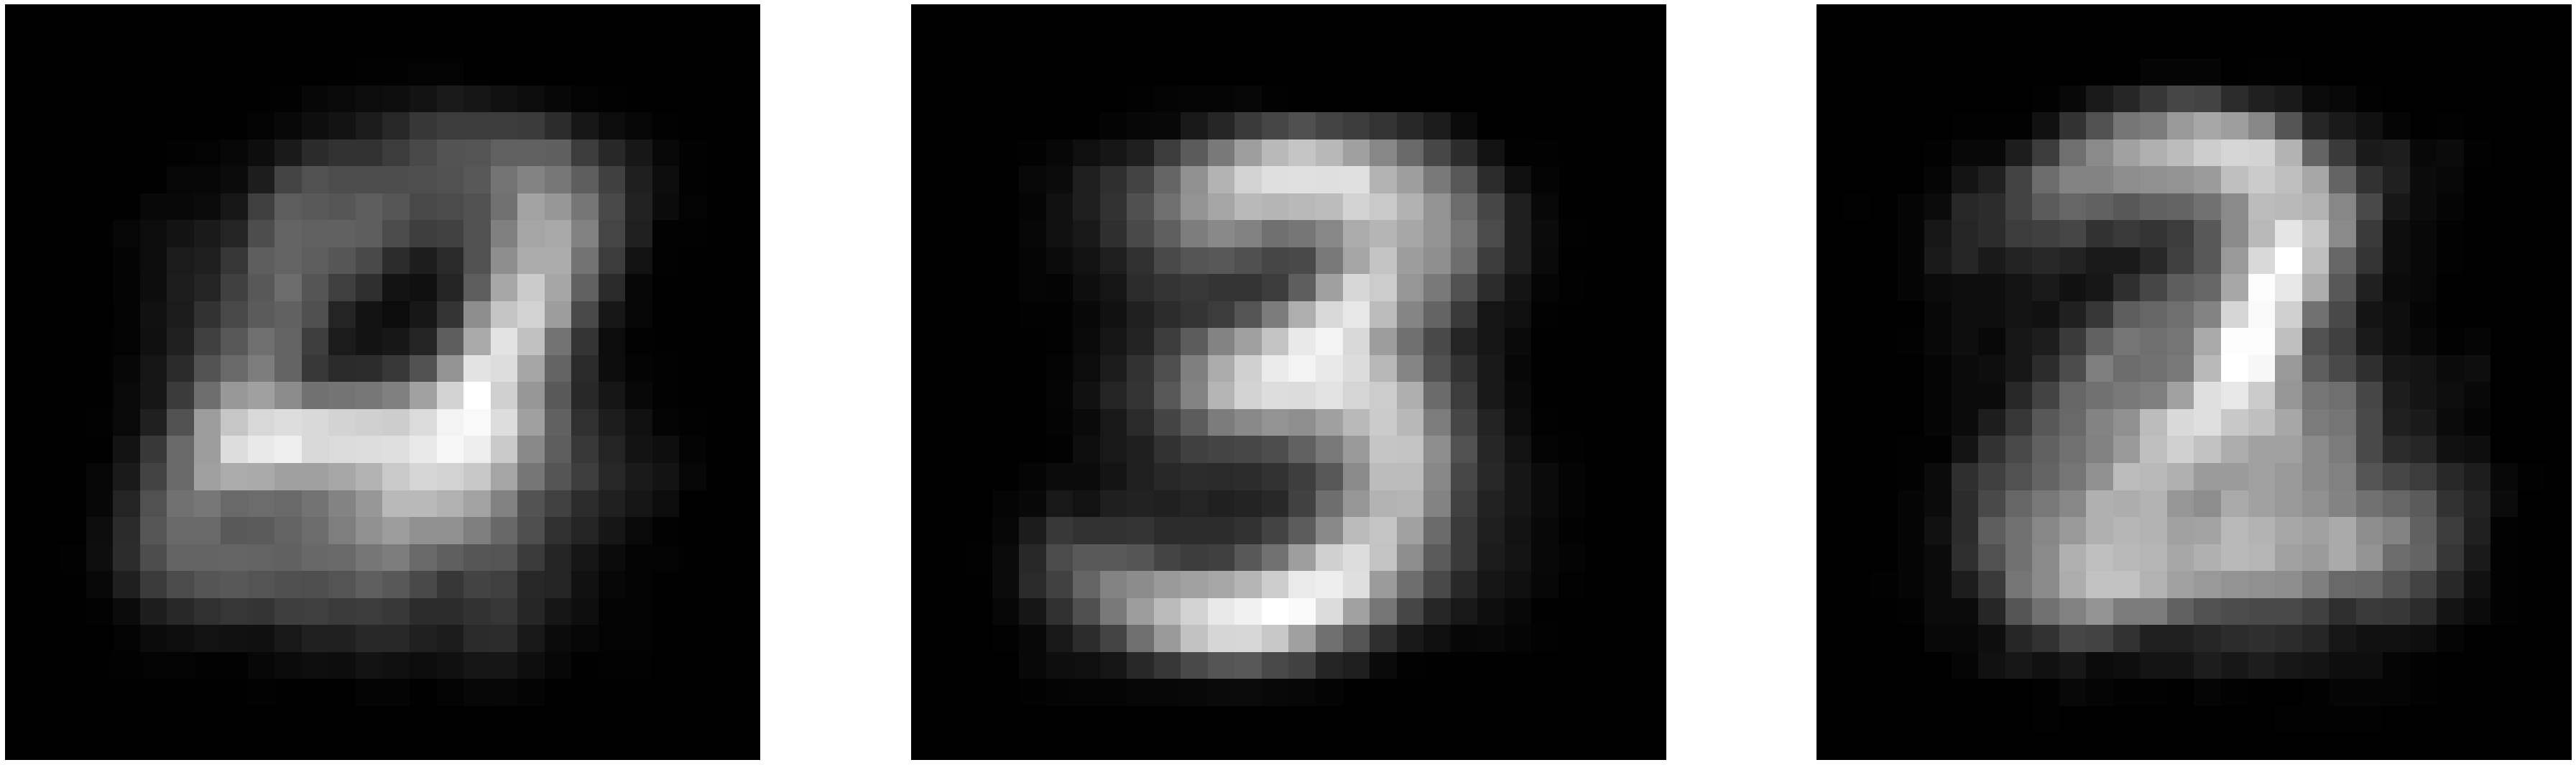

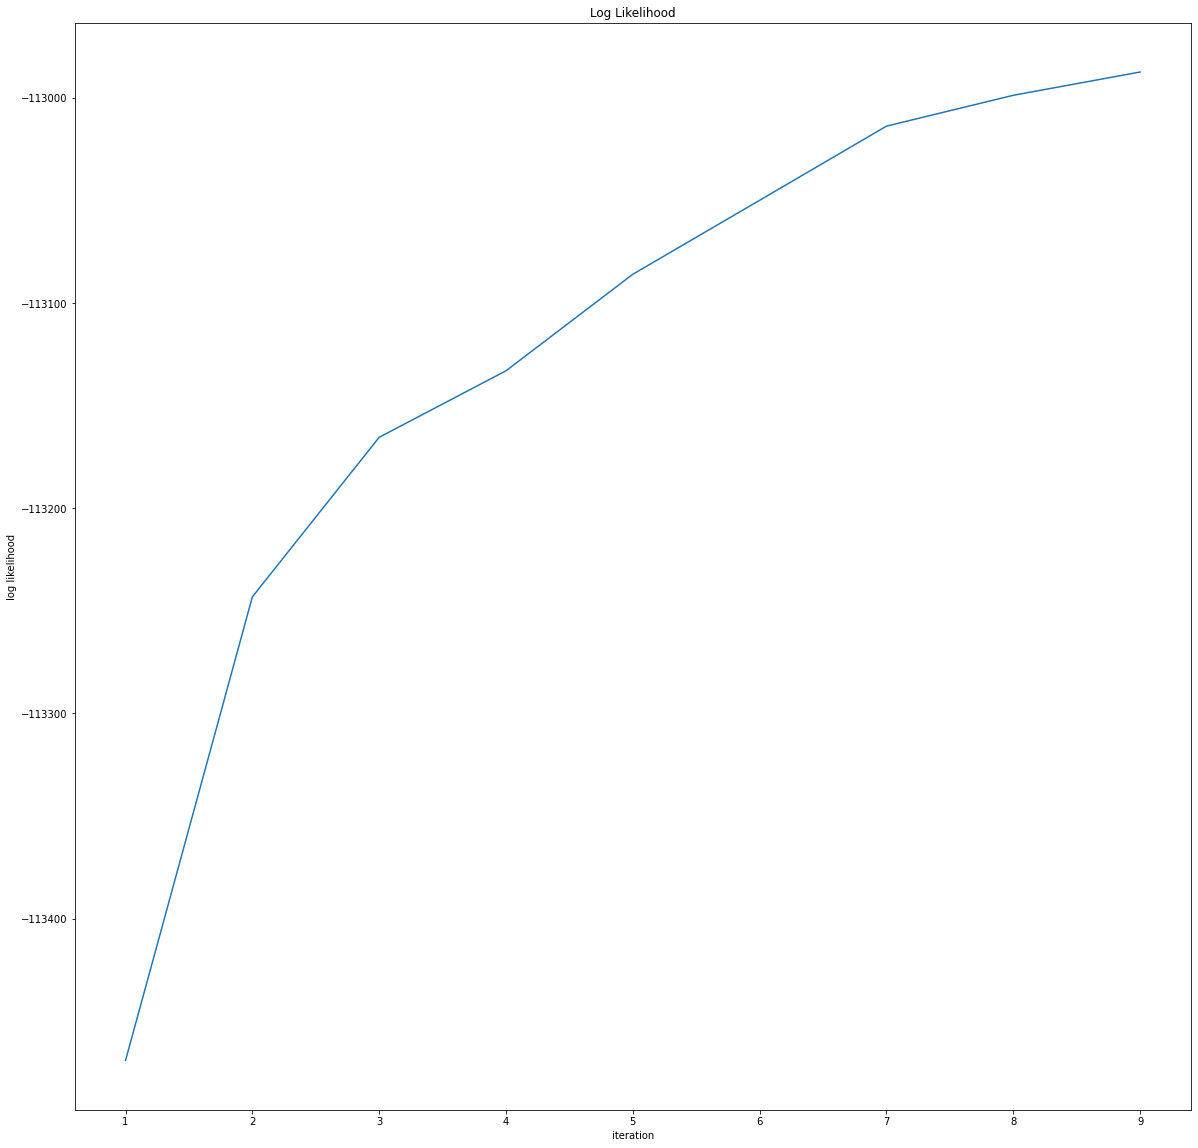

Images obtained after estimating the paramters of the mixture components


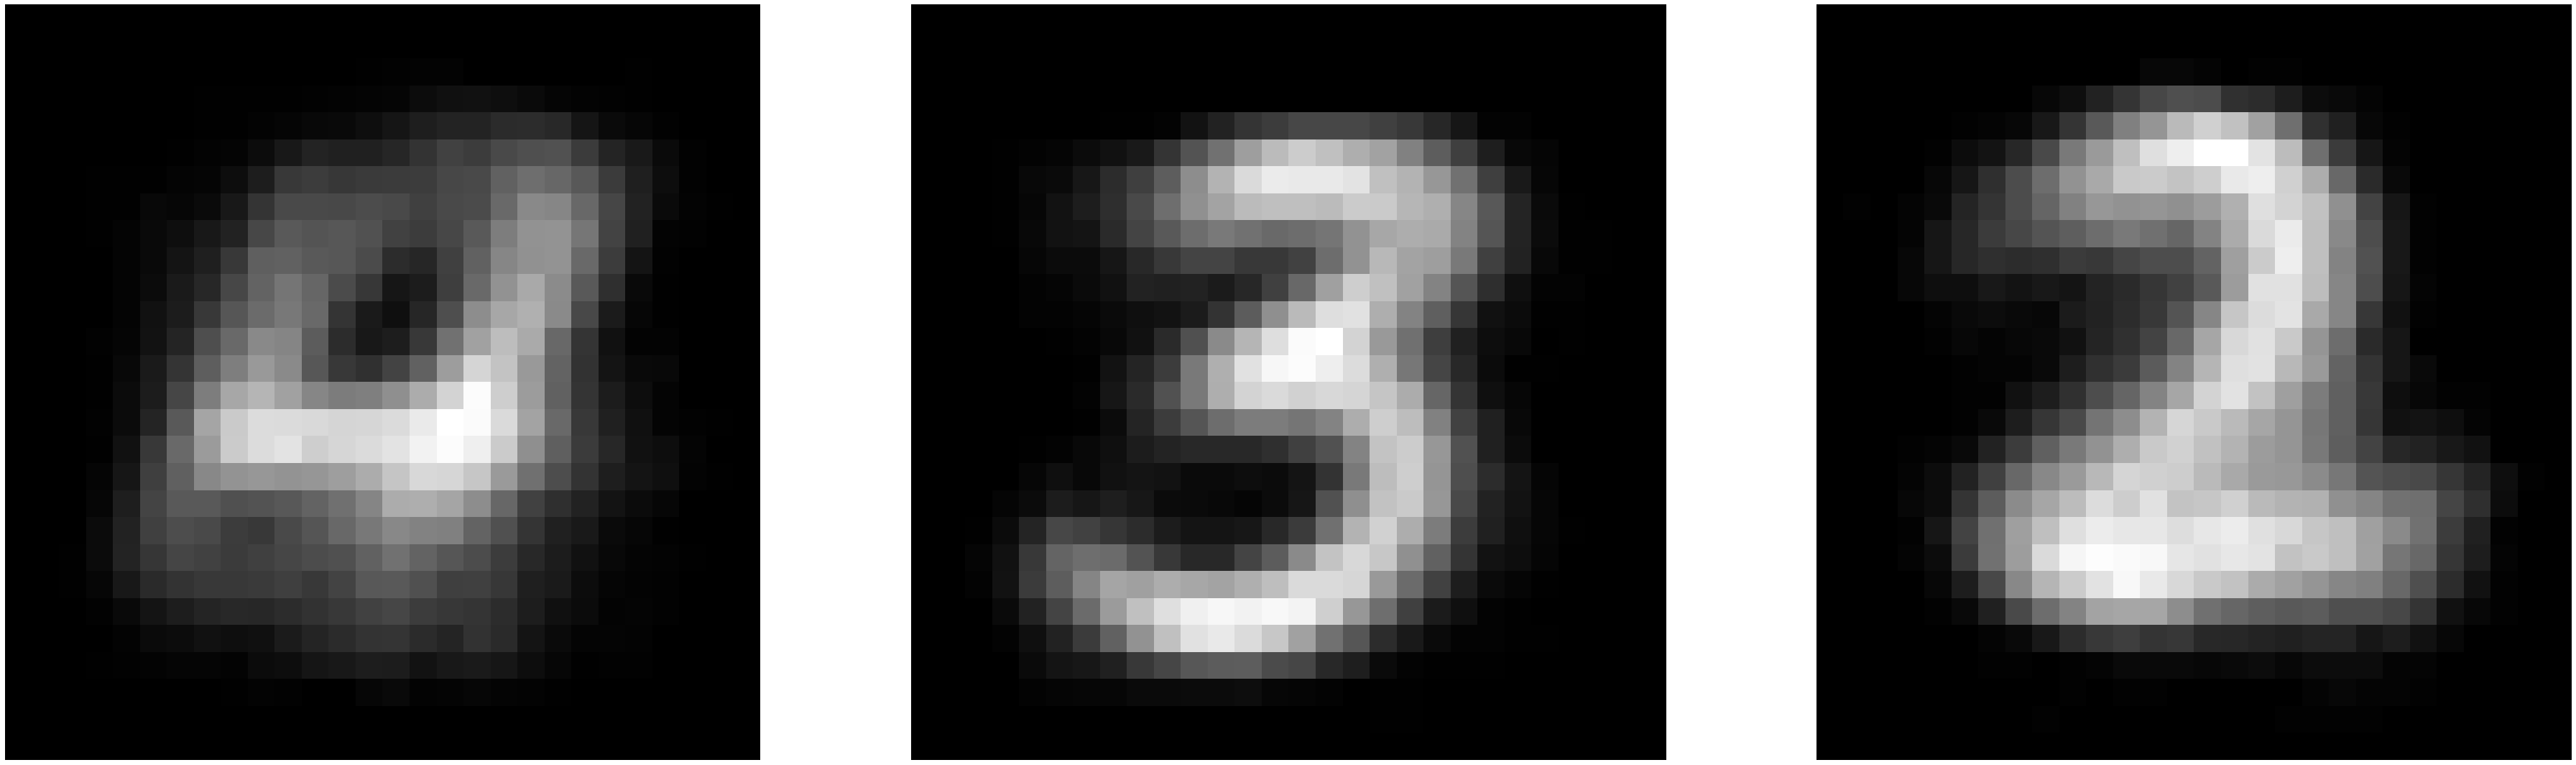

In [7]:
K=3  #no. of mixture components
iterations=10 #max. no. of iterations
img_size=784
P=init_using_kmeans(K,iter_kmeans=2) #initialisation_parameters(K,img_size)  #random initialisation of parameters 
#print(np.max(P["class_prob"+str(0)]))

   

log_likehood=np.zeros((iterations,1))
N_k=np.zeros((1,K))

#run EM algorithm 
log_likehood,P,res_coeff,iter_convg=em_algorithm(iterations,P,K,classes)
    #print(f"log_likelihood of class {i} is {log_likehood[i,:]}")

#print(log_likehood)
# dictonary={"class":range(0,10)}
# for i in range(10):
#     dictonary["L-L at iteration "+str(i)]=log_likehood[:,i]
# dataframe = pd.DataFrame(dictonary)

# display(dataframe)

#plot the log likelihood for each class
plt.figure(figsize=(20,20))
plt.title("Log Likelihood")
#plt.axis('off')

plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()
x=plt.figure(figsize=(64,64))    #to specify the figure size 
for i in range(K):
    plt.subplot(1,K,i+1)
    train_image=P["prob"+str(i)]
    #train_image=np.where(train_image>0.5,1, 0)
    train_image=np.reshape(train_image,(28,28))
    #train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
    plt.imshow(train_image,cmap='gray')
    plt.axis('off')

print("Images obtained after estimating the paramters of the mixture components") 

    #plt.title("Class "+str(i+2))
# x=plt.figure(figsize=(64,64))    #to specify the figure size
# x.suptitle("Images obtained after converting the feature values to binary values") 
# for i in range(K):
#     plt.subplot(1,K,i+1)
#     train_image=P["prob"+str(i)]
#     train_image=np.where(train_image>0.5,1, 0)
#     train_image=np.reshape(train_image,(28,28))
#     #train_imag1=train_imag1.reshape(int(np.sqrt(len(train_imag1))),int(np.sqrt(len(train_imag1))))
#     plt.imshow(train_image,cmap='gray')
#     plt.axis('off')
#     #plt.title("Class "+str(i+2))


